<a href="https://colab.research.google.com/github/madhurapg/madhurapg.github.io/blob/master/gif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip install tifffile
!pip install geopandas
!pip install carto2gpd
!pip install tornado==5.1.1
import tornado
!pip install holoviews

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import dask.array as da
import dask
import dask.dataframe as dd
#import carto2gpd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Import the dataset
file = open("/content/drive/My Drive/Data/public_cases_fc.csv")
req = pd.read_csv(file)
req.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon
0,2,8967058,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,30 Business Days,2015-01-11,2015-08-12,2015-02-19,5915 SUMMER ST,NaN,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.965869,-75.238483
1,3,8967059,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,413 S 49TH ST,19143,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.952385,-75.220374
2,4,8967064,Closed,Information Provided,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,309 S 48TH ST,NaN,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.952947,-75.218262
3,5,8967063,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,309 S 48TH ST,19143,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.952947,-75.218262
4,6,8967060,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,309 S 48TH ST,19143,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,39.952947,-75.218262


In [7]:
%%capture
!pip install datashader

In [8]:
# conversion to web mercator coordinate system
from datashader.utils import lnglat_to_meters
# create new columns 'x' (longitude) and 'y' (latitude)
req['x'], req['y'] = lnglat_to_meters(req['lon'], req['lat'])
# keep a clean dataframe 
req = req.drop(['lon', 'lat'], axis=1)

In [35]:
# Create date and time columns
req['requested_datetime'] = pd.to_datetime(req['requested_datetime'])
req['requested_datetime'].head()
req['Month'] = req['requested_datetime'].dt.month
req['Year'] = req['requested_datetime'].dt.year
req['Day'] = req['requested_datetime'].dt.dayofweek
req['Day_name'] = req['requested_datetime'].dt.day_name()
req.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,x,y,Month,Year,Day,Day_name
0,2,8967058,Closed,Issue Resolved,Abandoned Vehicle,SR-PD01,Police Department,30 Business Days,2015-01-11,2015-08-12,2015-02-19,5915 SUMMER ST,NaN,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,-8.375510e+06,4.860984e+06,1,2015,6,Sunday
1,3,8967059,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,413 S 49TH ST,19143,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,-8.373494e+06,4.859025e+06,1,2015,6,Sunday
2,4,8967064,Closed,Information Provided,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,309 S 48TH ST,NaN,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,-8.373259e+06,4.859107e+06,1,2015,6,Sunday
3,5,8967063,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,309 S 48TH ST,19143,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,-8.373259e+06,4.859107e+06,1,2015,6,Sunday
4,6,8967060,Closed,Issue Resolved,Graffiti Removal,SR-CL01,Community Life Improvement Program,7 Business Days,2015-01-11,2015-08-12,2015-01-19,309 S 48TH ST,19143,https://d21tc4b3k3r3vo.cloudfront.net/uploads/...,-8.373259e+06,4.859107e+06,1,2015,6,Sunday


In [36]:
req.Day.unique()

array([6, 1, 0, 2, 4, 5, 3])

In [37]:
# Get counts of requests by department
pd.options.display.max_rows = 4000
req.agency_responsible.unique()
counts = req.groupby('agency_responsible')['objectid'].nunique()
counts = counts.sort_values()
print(counts)

agency_responsible
Arts, Culture & Creative Economy                                             1
311 Contact Center                                                           2
Office of Emergency Management                                               2
Arts & Culture                                                               3
Philadelphia Redevelopment Authority                                         3
Public Property/ Historical Commission                                       3
Mayor's Office of Financial Empowerment                                      3
Office of LGBT Affairs                                                       4
Airport                                                                      5
Office of Emergency Management - OEM                                         5
Neighborhood Services                                                        6
Philadelphia Historical Commission                                           6
Mayor?s Office of Black Male Enga

In [38]:
# Convert to dask dataframe
data = dd.from_pandas(req, npartitions=1)
print('%s Rows' % len(data))
print('Columns:', list(data.columns))

3443944 Rows
Columns: ['objectid', 'service_request_id', 'status', 'status_notes', 'service_name', 'service_code', 'agency_responsible', 'service_notice', 'requested_datetime', 'updated_datetime', 'expected_datetime', 'address', 'zipcode', 'media_url', 'x', 'y', 'Month', 'Year', 'Day', 'Day_name']


In [12]:
import holoviews as hv

In [110]:
points = hv.Points(data, kdims=['x', 'y'])
from holoviews.operation.datashader import datashade
import datashader as ds
import datashader.transfer_functions as tf

# Color map imports
from datashader.colors import Greys9, viridis, inferno
from colorcet import fire, bmy, bmw, bgy, cwr

datashade(points, cmap=fire).opts(width=800, height=600, bgcolor="black")

plot_width = 900
plot_height = int(plot_width*1)

In [14]:
%%capture
!pip install esri2gpd

In [31]:
# add Philly zipcode boundaries (coords must be in 3857)
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Zipcodes_Poly/FeatureServer/0/"

import esri2gpd

zip_codes = esri2gpd.get(url)
zip_codes = zip_codes.to_crs(epsg=3857)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [89]:
 def create_image(df, x_range, y_range, Cmap, w=plot_width, h=plot_height):   
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot 311 requests positions
    agg = cvs.points(df, 'x', 'y',  ds.count())
    
    # shade
    img = tf.shade(agg, cmap=Cmap, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [111]:
def plot_violations_by_day(fig, ax, data_all_days, day, zip_codes, x_range, y_range):
    """
    Plot the violations for particular day of the week
    """
    #some_values = ['Fire Department'] #this can be used to filter data by agency responsible
    #fire_data = data_all_days.loc[data_all_days["agency_responsible"].isin(some_values)]

    # trim to the specific day of the week
    df_this_day = data_all_days.loc[data_all_days["Day"] == day]
    day_name = list(df_this_day["Day_name"])[0]
    
    # create the datashaded image
    img = create_image(df_this_day, x_range, y_range, cwr)

    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.set_axis_off()

    # plot the zipcode boundaries
    zip_codes.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="white")

    # add a text label for the day
    ax.text(
        0.05,
        0.9,
        "311 Service and Information \n Requests in Philadelphia",
        color="white",
        fontsize=20,
        ha="left",
        transform=ax.transAxes,
    )

    # add a title
    ax.text(
        0.6,
        0.1,
        day_name,
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )

    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [83]:
Philly = ((-75.28, -74.96), (39.86, 40.14))
x_range, y_range = [list(r) for r in lnglat_to_meters(Philly[0], Philly[1])]

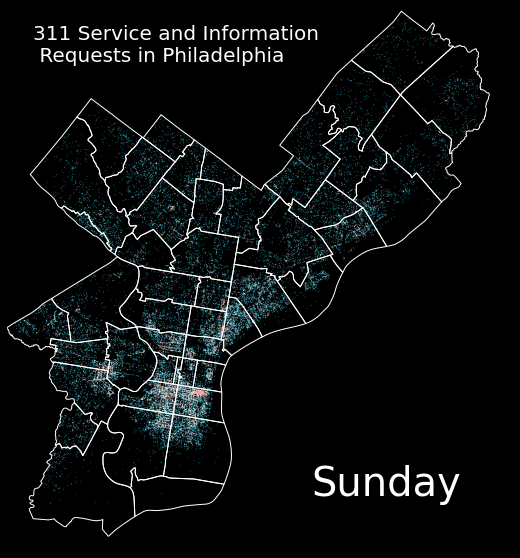

In [112]:
import imageio
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each month
imgs = []
for day in range(7):
    img = plot_violations_by_day(fig, ax, data, day, zip_codes, x_range=x_range, y_range=y_range)
    imgs.append(img)

In [113]:
# Combing the images for each month into a single GIF
imageio.mimsave('/content/drive/My Drive/Data/311_days.gif', imgs, fps=1);